# Testing Rietveld Phases

The goal of this notebook is to demonstrate the functionality of the `RietveldPhases` class, and to compile some tests which can be used to verify its proper functioning.

In [1]:
%matplotlib notebook
from __future__ import division
import numpy as np
import time
import matplotlib.pyplot as plt
from random import randrange

import sys, os
sys.path.append(os.path.abspath(".."))

from RietveldPhases import RietveldPhases
from RietveldRefinery import RietveldRefinery

from cctbx.eltbx import wavelengths

### Input Strings
In practice, one would want to initialize the `RietveldPhases` class by reading in some parameters from a file. However, for the purposes of testing, we have set things up to be read from an input string. To this end, we define the following input strings:

In [2]:
global_input_string = """\
Bkgd:          3
two_theta_0       0.001      -2.0  2.0
"""

phase_input_strings = ["""\
U              0.0   -0.1   0.1
V              0.0   -0.1   0.1
W              0.0006   -0.1   0.1
Amplitude         1 0      inf
eta:           2
""",
"""\
U              0.2   -0.1   0.1
V              0.3   -0.1   0.1
W              0.0008   -0.1   0.1
Amplitude         1 0      inf
eta:           2
"""]

There are two primary ways to list profile parameters in the input file/string:

* In the case where a single parameter is introduced: the label is given, along with its value and the lower, upper bounds of the range over which it can refine. 

* Alternatively, if a parameter will collectively represent a power series in $2\theta$: a single integer is listed, indicating the number of parameters appearing in the power series. (For example, a quadratic polynomial would consist of 3 parameters.) In this case, the lower, upper bounds are hard-coded.

We then define a list of the names of `.cif` cards for testing purposes, and read in some sample data:

In [3]:
cifs = ["1000032.cif","1507774.cif"]

tst_two_theta = []
tst_y = []

# with open(r"17_05_23_0014_NIST SRM 1976b.xye") as file:
# with open(r"16_01_07_0010_Aspirin_HighRez.xye") as file:
# with open(r"16_03_09_0015_Silver Behenate.xye") as file:
with open(r"Jade-Al2O3-Sim.xye") as file:
   for line in file.readlines():#[4:]:
      # two_thetatmp, ytmp, ztmp = line.split()
      two_thetatmp, ytmp = line.split()
      tst_two_theta.append(float(two_thetatmp))
      tst_y.append(float(ytmp))

tst_two_theta = np.array(tst_two_theta)
tst_y = 0.01*np.array(tst_y) #: re-scale to ease the fitting of amplitudes

In the last two lines, two numpy arrays &mdash; `tst_two_theta` and `tst_y` &mdash; are initialized, which store the test $2\theta$ and intensity values, respectively. 

We next initialize some boolean variables to control the behaviour of this notebook:

In [4]:
is_Sim_data = True #: Should be False unless the simulated 
   #: data from Jade-AL2O3-Sim.xye is used
display_plots = True #: Use to see sample plots

### Creating Rietveld Phases
From here, we can define two instances of `RietveldPhases` (one for each `.cif` file). However, we first require the minimum, maximum d-spacings needed (as dictated by the range of $2\theta$ values we just read in):

In [5]:
RietveldPhases.global_params_from_string(global_input_string,
                                            tst_two_theta,tst_y)

CU_wavelength = wavelengths.characteristic("CU").as_angstrom()
d_min = CU_wavelength/2/np.sin(np.pi/360*tst_two_theta[-1])
d_max = CU_wavelength/2/np.sin(np.pi/360*tst_two_theta[0])
Rt = []

for cif,input_string in zip(cifs,phase_input_strings):
   Rt.append(RietveldPhases(cif,input_string,d_min,d_max,delta_theta = 2.0,
        Intensity_Cutoff = 0.005))

### Test: Example &ndash; the _x_ Numpy Array
To verify that the input strings have been properly processed, we can perform some tests. As an example, consider the first of these:

In [6]:
assert np.isclose(RietveldPhases.x['values'][Rt[0].U_index], 0.0)

This statement checks to confirm that the value entered in the first input is indeed equal to 0.0 (i.e. the initial value read in for the first phase's Caglioti `U` parameter).

From the above, it should be clear that there exists a global parameter, `RietveldPhases.x` which stores all of the refinement parameters. In particular, it's a numpy array defined using a custom data-type consisting of:

* a label (string) describing the type of refinement parameter
* the value itself
* the lower limit of the refinement range
* the upper limit of the refinement range

```python
custom_dtype = np.dtype([ 
      ('labels','S12'), 
      ('values','f8'), 
      ('l_limits','f8'), 
      ('u_limits','f8') 
      ])
```

As such, `x['values']` represents a sub-array consisting of only the refinement parameter values. Similarly, `x['labels']` consists of parameter labels, etc.

Whenever a new `RietveldPhases` instance is created, the indices corresponding to the positions of that phase's refinement parameters in `x` are stored as instance variables. For example, in the above the variable `U_index` is used to extract `Rt[0]`'s _U_ parameter from the global array `x`.

In [7]:
#Testing Read-in from input_string
assert RietveldPhases.x['labels'][Rt[0].U_index] == 'U'
assert np.isclose(Rt[1].x['values'][Rt[1].U_index], 0.2)
assert RietveldPhases.x['labels'][Rt[1].U_index] == 'U'
assert np.isclose(Rt[0].x['values'][Rt[0].V_index], 0.0)
assert RietveldPhases.x['labels'][Rt[0].V_index] == 'V'
assert np.isclose(Rt[0].x['values'][Rt[0].W_index],  0.0006)
assert np.isclose(RietveldPhases.x['values'] \
   [RietveldPhases.two_theta_0_index] , np.array([0.001]))
assert len(RietveldPhases.x['values'] \
   [np.char.startswith(RietveldPhases.x['labels'],"Bkgd")]) == 3
assert np.all(np.isclose(RietveldPhases.x['values'] \
   [np.char.startswith(RietveldPhases.x['labels'],"Bkgd")], \
   np.array([0.,0.,0.])))

### Test: `.cif` Card Reading

We can now also test that the `.cif` cards have been loaded properly. In particular, we can verify that the unit-cell parameters for each instance match with our expectation:

In [8]:
   # Testing iotbx output from .cif card
   np.set_printoptions(threshold=None)
   assert np.all(np.isclose(np.array(Rt[0].unit_cell.parameters()), 
        np.array([4.7605, 4.7605, 12.9956, 90., 90., 120.])))
   assert np.all(np.isclose(np.array(Rt[1].unit_cell.parameters()), 
        np.array([4.1769, 4.7218, 58.3385, 89.44, 89.634, 75.854])))

### Test: Output Data from `.cif` Card Read-in

Further to this, we also check that the _d_-spacings and relative intensities computed given the `.cif` data are reliable, relative to some expected values:

In [9]:
#Testing d-spacing outputs
assert np.all(np.isclose(Rt[0].d_spacings[0:30], np.array(
   [  3.48114434e+00,   2.55177292e+00,   2.38025000e+00,
       2.08607570e+00,   1.96485460e+00,   1.74057217e+00,
       1.60196736e+00,   1.54715716e+00,   1.51527741e+00,
       1.51135808e+00,   1.40499663e+00,   1.37423798e+00,
       1.33645880e+00,   1.27588646e+00,   1.23944057e+00,
       1.23455034e+00,   1.19354167e+00,   1.19012500e+00,
       1.16038145e+00,   1.16038145e+00,   1.14760201e+00,
       1.13903464e+00,   1.12613194e+00,   1.12452033e+00,
       1.09932894e+00])))
assert np.all(np.isclose(Rt[1].d_spacings[0:30], np.array(
   [ 14.58380434,  11.66704347,   9.72253623,   8.33360248,
      7.29190217,   6.48169082,   5.83352174,   5.30320158,
      4.86126811,   4.57845246,   4.56140325,   4.5289481 ,
      4.51721072,   4.48732441,   4.4650281 ,   4.35771092,
      4.27435487,   4.24980397,   4.16680124,   4.1557422 ,
      4.02715497,   4.00946117,   3.99846875,   3.96837552,
      3.90666115,   3.89836103,   3.89236416,   3.88901449,
      3.83110776,   3.75460982])))

#Testing Relative Intensity Outputs
assert np.all(np.isclose(Rt[0].relative_intensities[0:30], np.array(
   [ 0.19906132,  0.61069362,  0.29855677,  1.18211397,  0.01740687,
     0.86296333,  2.11656703,  0.05664854,  0.08304719,  0.18443051,
     1.14926644,  1.85168419,  0.03841942,  0.0587068 ,  0.69865033,
     0.35418387,  0.03049309,  0.29644002,  0.02099137,  0.02108226,
     0.24097501,  0.01391577,  0.18603062,  0.14235153,  0.40296412])))
# print repr(Rt[1].relative_intensities[0:30])
assert np.all(np.isclose(Rt[1].relative_intensities[0:30], np.array(
   [ 0.00991668,  0.01230013,  0.00716603,  0.00855396,  0.00426061,
     0.00530974,  0.00224645,  0.00295588,  0.00115554,  0.02576297,
     0.00280861,  0.00032264,  0.02274331,  0.00189005,  0.00051361,
     0.00231178,  0.00158587,  0.00066494,  0.00048172,  0.00081688,
     0.00166894,  0.00044647,  0.00100012,  0.00176042,  0.00089117,
     0.00087474,  0.00128861,  0.0011674 ,  0.0561287 ,  0.00185326])))

### Test: Input Data Read-in

We can also verify that the test data have been read in correctly:

In [10]:
#Testing test-data read-in
if is_Sim_data:
   np.set_printoptions(threshold=None)
   assert str(tst_two_theta) == \
   """[  5.     5.02   5.04 ...,  89.96  89.98  90.  ]"""
   assert str(tst_y) == \
   """[ 0.01  0.01  0.01 ...,  0.02  0.02  0.02]"""

### Test: Background Polynomial

The background polynomial, $I_0(2\theta)$ &ndash; when initialized with _N_ parameters &ndash; is defined as follows:
$$ I_0(2\theta) := \sum_{k=0}^N I_{0k}\,(2\theta)^k \,.$$

Below we verify that the global function, `RietveldPhases.Background_Polynomial(two_theta)`$= I_0(2\theta)$, is producing reasonable results in the particular case where
$$I_0(2\theta) = 1+2\,(2\theta)+3\,(2\theta)^2 \,.$$
Testing with the sample values `[0, 1, 2.3, 100.5]`, we expect to get 
$$I_0([0, 1, 2.3, 100.5]) = [1, 6, 21.47, 30502.75]$$

In [11]:
# Testing Background_Polynomial
RietveldPhases.x['values'] \
   [np.char.startswith(RietveldPhases.x['labels'],"Bkgd")]  \
   = np.array([1.0,2.0,3.0])
tst_bkgd_two_theta = np.array([0,1,2.3,100.5])
assert np.all(np.isclose(RietveldPhases.Background_Polynomial( \
   tst_bkgd_two_theta) , np.array([1,6,21.47,30502.75])))

#Revert back to flat background
RietveldPhases.x['values'] \
   [np.char.startswith(RietveldPhases.x['labels'],"Bkgd")]  \
   = np.array([0.0,0.0,0.0])

## Pseudo-Voigt Profile Function

In the above, `phase_input_string` contains a list of strings, each containing the parameters needed to compute each phase's diffraction profile. `U`, `V`, and `W` are the Caglioti parameters, `two_theta_0`$=2\theta_0$ is an overall rescaling, and `eta_Polynomial(two_theta)`$=\eta(2\theta)$ is the Pseudo-Voigt weighting parameter:
$$PV(2\theta,2\theta_{\rm peak}) = \frac{\eta(2\theta)}{1+\overline{\Delta\theta}^2}
         +\left[1-\eta(2\theta)\right]2^{-\overline{\Delta\theta}^2} \quad{\rm where}
         \quad
         \overline{\Delta\theta}^2 
         := \frac{(2\theta-2\theta_0-2\theta_{\rm peak})^2}{\left| U\,tan^2\theta_{\rm peak} + V\,\tan\theta_{\rm peak} 
    +W \right|} \,.$$

### Test: Eta Polynomial

The astute reader will note that the eta parameter is read in similarly to the background polynomial, $I_0(2\theta)$. This is because it is, in fact, a polynomial in $2\theta$:
$$ \eta(2\theta) = \sum_{k=0}^N \eta_k \,(2\theta)^k$$
Below we verify that the instance function, `self.Background_Polynomial`$= \eta(2\theta)$, is producing reasonable results in the particular case where
$$\eta(2\theta) = 0.5+0.005\,(2\theta) \,.$$
Testing with the sample values `[0, 1, 2.3, 100.5]`, we expect to get 
$$\eta([0, 1, 2.3, 100.5]) = [0.5, 0.505, 0.5115, 1.0025]$$

In [12]:
# Testing Eta_Polynomial
Rt0_eta_mask = np.isin(np.array(range(0,len(RietveldPhases.x))), \
   np.array(range(Rt[0].eta_0_index,Rt[0].eta_0_index+Rt[0].eta_rank)))
RietveldPhases.x['values'][Rt0_eta_mask] = np.array([0.5,0.005])
tst_eta_two_theta = np.array([0,1,2.3,100.5])
assert np.all(np.isclose(Rt[0].eta_Polynomial( \
   tst_eta_two_theta) , np.array([ 0.5, 0.505, 0.5115, 1.0025])))
#Revert back to unbiased eta
RietveldPhases.x['values'][Rt0_eta_mask] = np.array([0.5,0.00])

In [13]:
# Testing LP_Intensity_Scaling
assert np.isclose(Rt[0].LP_Intensity_Scaling(20.0),31.7054214503)

In [14]:
# Testing two_theta outputs
assert np.all(np.isclose(Rt[0].two_theta_peaks[0:10], np.array(
   [[ 25.56751716],
    [ 35.13879293],
    [ 37.76313851],
    [ 43.33853666],
    [ 46.16161879],
    [ 52.53263976],
    [ 57.47974186],
    [ 59.71809269],
    [ 61.10698338],
    [ 61.28247987]])))

#Testing Weighted Intensity outputs
assert np.all(np.isclose(Rt[0].weighted_intensities[0:10], np.array(
   [[ 0.19906132],
    [ 0.61069362],
    [ 0.29855677],
    [ 1.18211397],
    [ 0.01740687],
    [ 0.86296333],
    [ 2.11656703],
    [ 0.05664854],
    [ 0.08304719],
    [ 0.18443051]])))

<IPython.core.display.Javascript object>


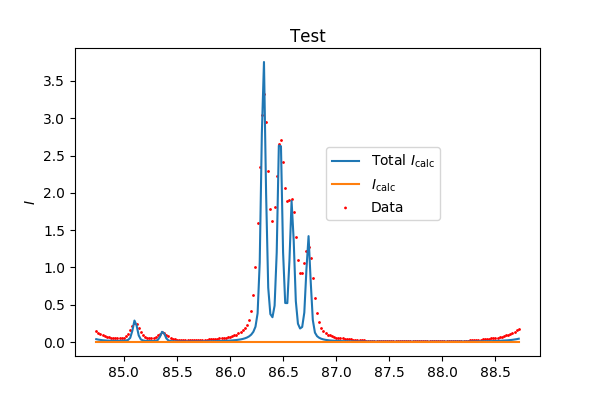

<IPython.core.display.Javascript object>


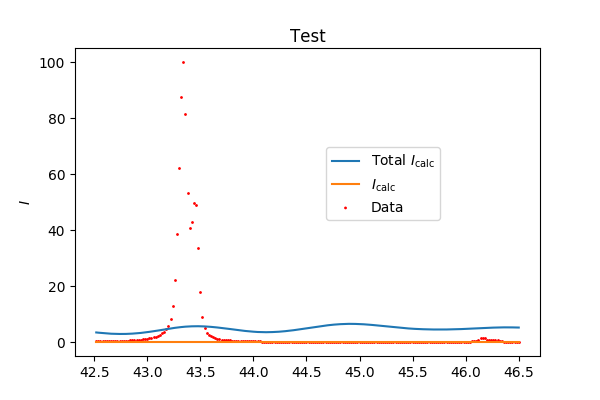

<IPython.core.display.Javascript object>


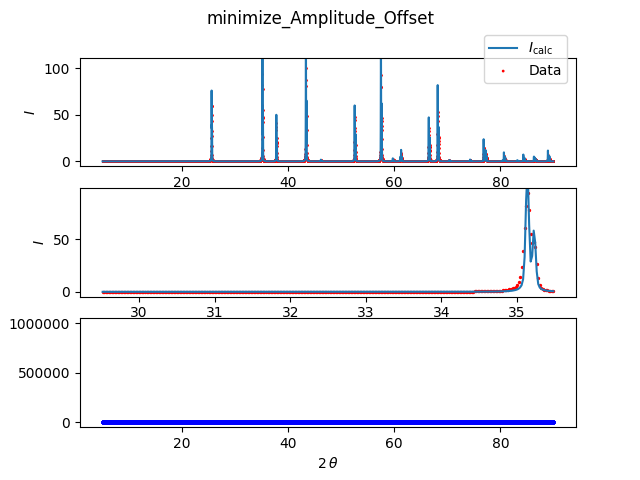

two_theta_0 = 0.001 (-2.0, 2.0)
Amplitude = 13.8760679015 (0.0, inf)
Amplitude = 19.0553599088 (0.0, inf)
.................

After minimize_Amplitude_Offset:
two_theta_0 = -0.00286892315225 (-2.0, 2.0)
Amplitude = 20.1546289826 (0.0, inf)
Amplitude = 0.00973130955643 (0.0, inf)

Time taken to run minimize_Amplitude_Offset: 10.842 seconds
R_wp: 0.434368832771
R_e: 0.933947041266
Goodness-of-Fit: 0.465089361151


Phase 1: 99.9517400532 %
Phase 2: 0.048259946834 %




<IPython.core.display.Javascript object>


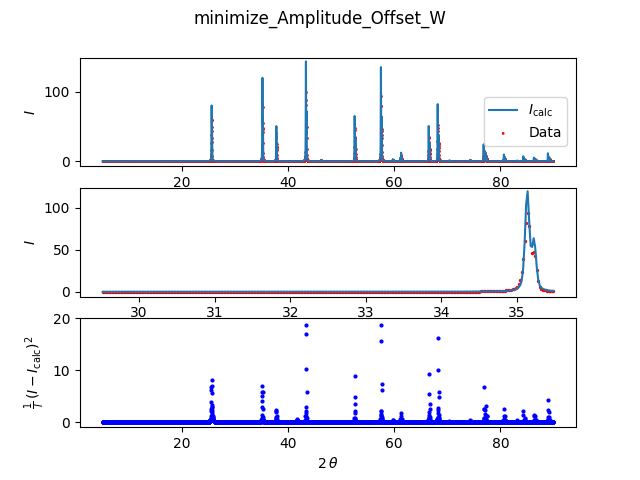

two_theta_0 = -0.00286892315225 (-2.0, 2.0)
W = 0.0006 (-0.1, 0.1)
Amplitude = 20.1546289826 (0.0, inf)
W = 0.0008 (-0.1, 0.1)
Amplitude = 0.00973130955643 (0.0, inf)
.....................

After minimize_Amplitude_Offset_W:
two_theta_0 = -0.00415491584769 (-2.0, 2.0)
W = 0.00110227262288 (-0.1, 0.1)
Amplitude = 20.1540550045 (0.0, inf)
W = 0.000689880739429 (-0.1, 0.1)
Amplitude = 0.006303233105 (0.0, inf)

Time taken to run minimize_Amplitude_Offset_W: 14.838 seconds
R_wp: 0.31871659638
R_e: 0.933947041266
Goodness-of-Fit: 0.34125767554


Phase 1: 99.9687345184 %
Phase 2: 0.0312654816482 %




<IPython.core.display.Javascript object>


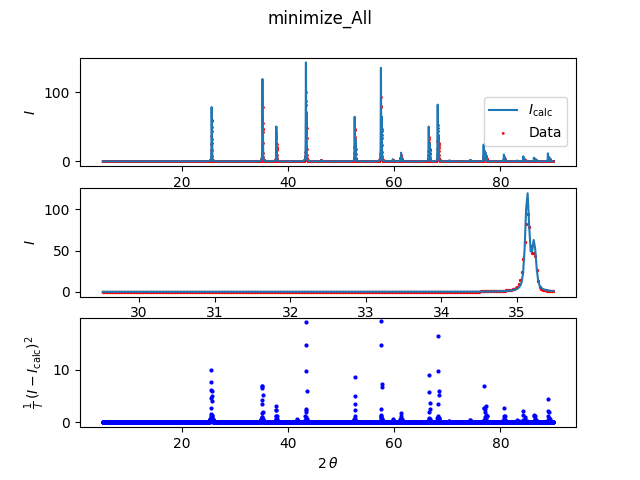

Bkgd_0 = 0.0 (-inf, inf)
Bkgd_1 = 0.0 (-inf, inf)
Bkgd_2 = 0.0 (-inf, inf)
two_theta_0 = -0.00415491584769 (-2.0, 2.0)
U = 0.0 (-0.1, 0.1)
V = 0.0 (-0.1, 0.1)
W = 0.00110227262288 (-0.1, 0.1)
Amplitude = 20.1540550045 (0.0, inf)
eta_0 = 0.5 (0.0, 1.0)
eta_1 = 0.0 (0.0, 0.001)
U = 0.2 (-0.1, 0.1)
V = 0.3 (-0.1, 0.1)
W = 0.000689880739429 (-0.1, 0.1)
Amplitude = 0.006303233105 (0.0, inf)
eta_0 = 0.5 (0.0, 1.0)
eta_1 = 0.0 (0.0, 0.001)
............................................................

After minimize_All:
Bkgd_0 = 0.000336823732221 (-inf, inf)
Bkgd_1 = 0.000450557715908 (-inf, inf)
Bkgd_2 = -5.19811490372e-06 (-inf, inf)
two_theta_0 = -0.00373216295476 (-2.0, 2.0)
U = -0.000867811973365 (-0.1, 0.1)
V = 0.00136023574158 (-0.1, 0.1)
W = 0.000618752770937 (-0.1, 0.1)
Amplitude = 20.153963612 (0.0, inf)
eta_0 = 0.50028300868 (0.0, 1.0)
eta_1 = 0.001 (0.0, 0.001)
U = 0.099999069882 (-0.1, 0.1)
V = 0.0999959149345 (-0.1, 0.1)
W = 0.000667918629579 (-0.1, 0.1)
Amplitude = 0.0059185001

In [15]:
#Testing test-data read-in
if is_Sim_data:
   np.set_printoptions(threshold=None)
   assert str(tst_two_theta) == \
   """[  5.     5.02   5.04 ...,  89.96  89.98  90.  ]"""
   assert str(tst_y) == \
   """[ 0.01  0.01  0.01 ...,  0.02  0.02  0.02]"""

# Testing Background_Polynomial
RietveldPhases.x['values'] \
   [np.char.startswith(RietveldPhases.x['labels'],"Bkgd")]  \
   = np.array([1.0,2.0,3.0])
tst_bkgd_two_theta = np.array([0,1,2.3,100.5])
assert np.all(np.isclose(RietveldPhases.Background_Polynomial( \
   tst_bkgd_two_theta) , np.array([  1,6,21.47,   3.05027500e+04])))
#Revert back to flat background
RietveldPhases.x['values'] \
   [np.char.startswith(RietveldPhases.x['labels'],"Bkgd")]  \
   = np.array([0.0,0.0,0.0])

# Testing Eta_Polynomial
Rt0_eta_mask = np.isin(np.array(range(0,len(RietveldPhases.x))), \
   np.array(range(Rt[0].eta_0_index,Rt[0].eta_0_index+Rt[0].eta_rank)))
RietveldPhases.x['values'][Rt0_eta_mask] = np.array([0.5,0.005])
tst_eta_two_theta = np.array([0,1,2.3,100.5])
assert np.all(np.isclose(Rt[0].eta_Polynomial( \
   tst_eta_two_theta) , np.array([ 0.5, 0.505, 0.5115, 1.00249999])))
#Revert back to unbiased eta
RietveldPhases.x['values'][Rt0_eta_mask] = np.array([0.5,0.00])

# Testing LP_Intensity_Scaling
assert np.isclose(Rt[0].LP_Intensity_Scaling(20.0),31.7054214503)

# Testing two_theta outputs
assert np.all(np.isclose(Rt[0].two_theta_peaks[0:10], np.array(
   [[ 25.56751716],
    [ 35.13879293],
    [ 37.76313851],
    [ 43.33853666],
    [ 46.16161879],
    [ 52.53263976],
    [ 57.47974186],
    [ 59.71809269],
    [ 61.10698338],
    [ 61.28247987]])))

#Testing Weighted Intensity outputs
assert np.all(np.isclose(Rt[0].weighted_intensities[0:10], np.array(
   [[ 0.19906132],
    [ 0.61069362],
    [ 0.29855677],
    [ 1.18211397],
    [ 0.01740687],
    [ 0.86296333],
    [ 2.11656703],
    [ 0.05664854],
    [ 0.08304719],
    [ 0.18443051]])))

#Testing PseudoVoigtProfile
if display_plots:
   for RV in Rt:
      #Select a random peak:
      if len(RV.two_theta_peaks) != 0:
         rnd_index = randrange(0,len(RV.two_theta_peaks),1)
         RV.showPVProfilePlot("Test",rnd_index, autohide=False)

minimizer_input_string = """\
approx_grad True
factr       1e9
maxiter     150
iprint      -1
m           10
pgtol       1e-5
epsilon     1e-10
"""

#Testing Refinery
RR = RietveldRefinery(Rt,minimizer_input_string,
   store_intermediate_state=True)

RR.display(RR.minimize_Amplitude_Offset)
RR.display(RR.minimize_Amplitude_Offset_W)
RR.display(RR.minimize_All)


# def run():
#    exercise_RietveldPhases()
#    print "OK"

# if (__name__ == "__main__"):
#    run()